# EWC and System Identification

This file is an implementation of Sasha Petrenko's final project in EE5320

## Summary

- Document: Final Project
- Author: Sasha Petrenko
- Class: EE5320
- Date: 12/14/2021

## Description

This file explores the problem of function regression of two functions with the same network.
This problem is tackled by having two separate head layers with a shared hidden layer which is tuned with Elastic Weight Consolidation (EWC).
This architecture is equivalent to having an output layer of multiple nodes and calculating the loss upon one output at a time.
Because this setup is chosen, only the weights of the input and hidden layers are tuned.

In [ ]:
# General tensorflow name import
import tensorflow as tf
# Layers and other functional API imports for convenience
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
# Utility imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

# Inline plotting for notebooks
%matplotlib inline

!!! note NOTE

In [ ]:
# Set the random seed for reproducibility
tf.random.set_seed(1234)
# Set the top directory for saving
topdir = Path("drive/MyDrive/colab/EE5320")
# Set the plotting dots-per-inch
dpi = 250

## Function Definitions

Define the relevant problem functions

In [ ]:
# The target function
def f_u(u):
    return 0.6*np.sin(np.pi*u) + 0.3*np.sin(3*np.pi*u) + 0.1*np.sin(5*np.pi*u)

# The target function
def f_u_2(u):
    return 0.6*np.sin(3*np.pi*u) + 0.3*np.sin(5*np.pi*u) + 0.1*np.sin(np.pi*u)
    # return 0.6*np.sin(np.pi*u+np.pi) + 0.3*np.sin(3*np.pi*u+np.pi) + 0.1*np.sin(5*np.pi*u+np.pi)

# The reference input to the model
def u_k(k):
    return np.sin(2*np.pi*k/250)

## Data Setup

Setup the train/test data and visualization data.

In [ ]:
# Visualization data
x_range = 2         # Symmetrical range from 0
n_elements = 100    # Number of samples from -x_range to x_range
x_vis = np.linspace(-x_range, x_range, num=n_elements)
# Compute the target output on the reference interval
f_vis = f_u(x_vis)
f_2_vis = f_u_2(x_vis)

# Train/test data
n_train = int(1e6)  # Number of training samples

# Set 1
x_data = (2*np.random.rand(n_train)-1)
y_data = f_u(x_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)

# Set 2
y_data_2 = f_u_2(x_data)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(x_data, y_data_2, test_size=0.20, random_state=42)

## Visualization

Visualize the target function

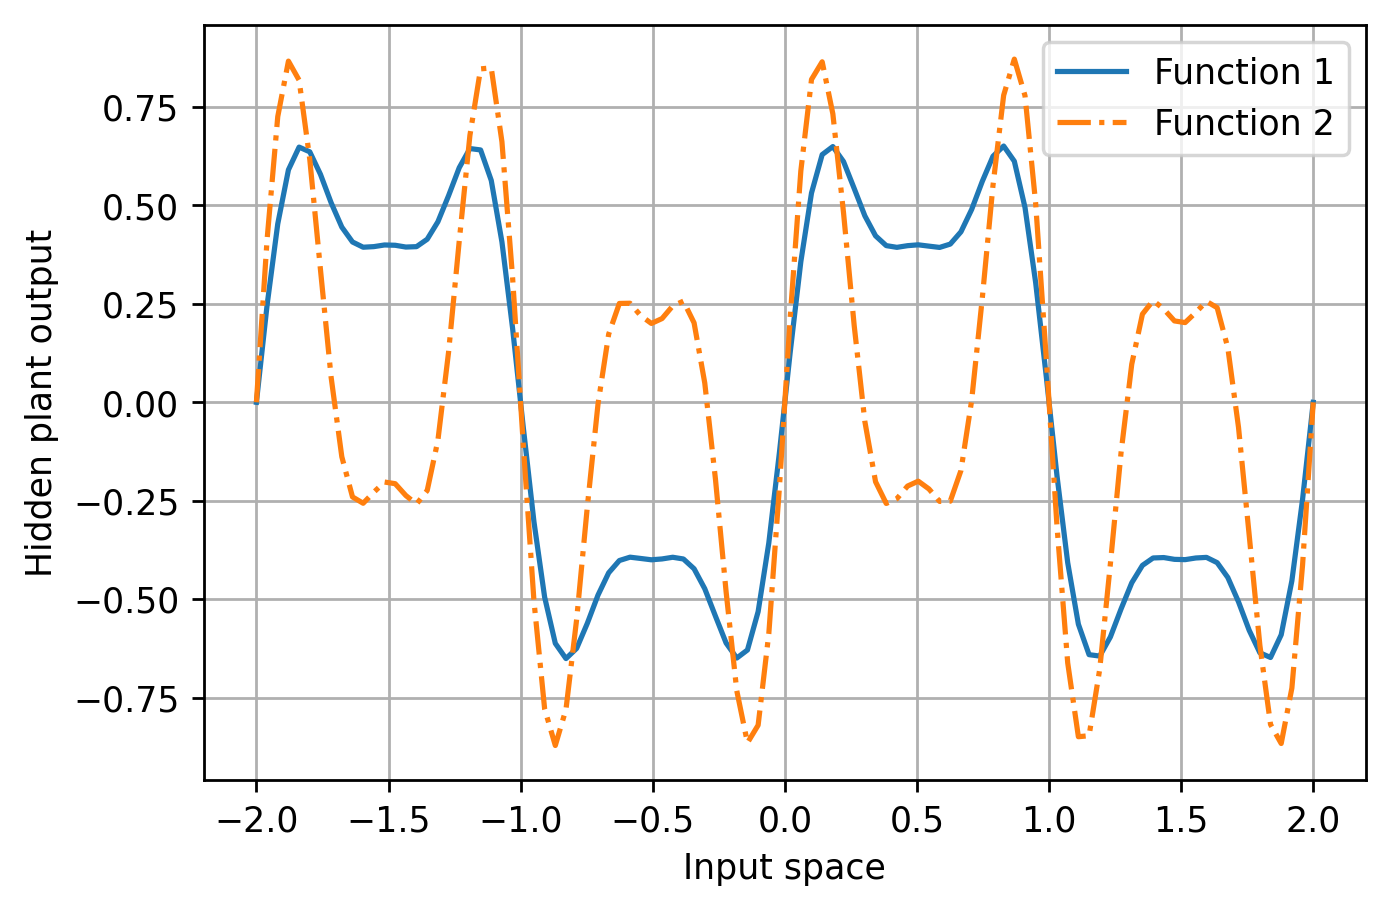

In [ ]:
# Plot the function on the reference interval
fig, ax = plt.subplots(dpi=dpi)
ax.plot(x_vis, f_vis, label="Function 1")
ax.plot(x_vis, f_2_vis, linestyle="-.", label="Function 2")
plt.xlabel("Input space")
plt.ylabel("Hidden plant output")
plt.grid(True)
ax.legend()
fig.show()
plt.savefig(topdir.joinpath("images", "plant.png"))

## Create the models

After creating the functions to approximate via regression, we must create the models.
Because we wish to create a model with multiple separate outputs, this is most easily done with the Keras functional API.
In this way, we can create graphs that are more complex than simple sequential models.

So that we do not have to create a separate training loop or loss function to only penalize the performance of one node, we instead create two networks that share the same hidden layers in memory while having differing output nodes.

In [ ]:
# Create a single layer instar network
def get_ewc_models():
    A1 = Input(shape=(1,), name='A1')
    A2 = Dense(10, activation='sigmoid', name='A2')(A1)
    A3 = Dense(10, activation='sigmoid', name='A3')(A2)

    B1 = Dense(1, activation='linear', name='B1')(A3)

    B2 = Dense(1, activation='linear', name='B2')(A3)

    model_1 = Model(inputs=[A1], outputs=[B1], name='model_1')
    model_1.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')

    model_2 = Model(inputs=[A1], outputs=[B2], name='model_2')
    model_2.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')

    return model_1, model_2


model_1, model_2 = get_ewc_models()

model_1.summary()
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 A1 (InputLayer)             [(None, 1)]               0         
                                                                 
 A2 (Dense)                  (None, 10)                20        
                                                                 
 A3 (Dense)                  (None, 10)                110       
                                                                 
 B1 (Dense)                  (None, 1)                 11        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 A1 (InputLayer)             [(None, 1)]    

We can visualize the same information above about the networks' architectures in a standard publication form.

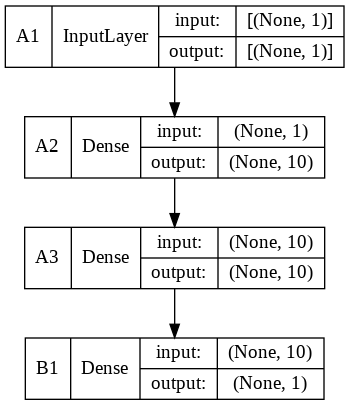

In [ ]:
# Plot the first model's architecture
tf.keras.utils.plot_model(model_1, to_file=topdir.joinpath('images', 'model_1_arch.png'),show_shapes=True)

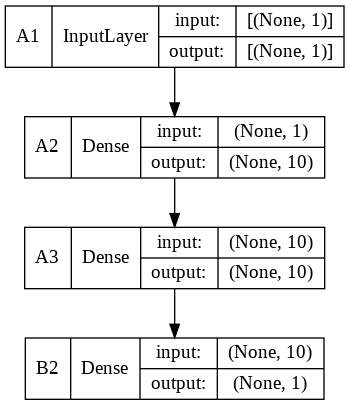

In [ ]:
# Plot the second model's architecture
tf.keras.utils.plot_model(model_2, to_file=topdir.joinpath('images', 'model_2_arch.png'),show_shapes=True)

## Train the First Model

Now, we train the first model to get a baseline.
We do this across 50 epochs and with a set of parameters that gives us an acceptable degree of convergence at the end.

In [ ]:
# Train
batch_size = 256
history = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
2500/2500 [==============================] - 7s 3ms/step - loss: 0.0863 - mae: 0.2220 - val_loss: 0.0683 - val_mae: 0.1871
Epoch 2/50
2500/2500 [==============================] - 6s 2ms/step - loss: 0.0571 - mae: 0.1718 - val_loss: 0.0318 - val_mae: 0.1412
Epoch 3/50
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0182 - mae: 0.1120 - val_loss: 0.0130 - val_mae: 0.0889
Epoch 4/50
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0121 - mae: 0.0826 - val_loss: 0.0118 - val_mae: 0.0799
Epoch 5/50
2500/2500 [==============================] - 6s 2ms/step - loss: 0.0117 - mae: 0.0792 - val_loss: 0.0116 - val_mae: 0.0787
Epoch 6/50
2500/2500 [==============================] - 6s 2ms/step - loss: 0.0116 - mae: 0.0775 - val_loss: 0.0116 - val_mae: 0.0775
Epoch 7/50
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0114 - mae: 0.0762 - val_loss: 0.0114 - val_mae: 0.0759
Epoch 8/50
2500/2500 [==============================] - 5s 2ms

## Visualize Regression

After training, we can visualize the regression results on the smaller visualization dataset (i.e., in $x\in [-1, 1$).

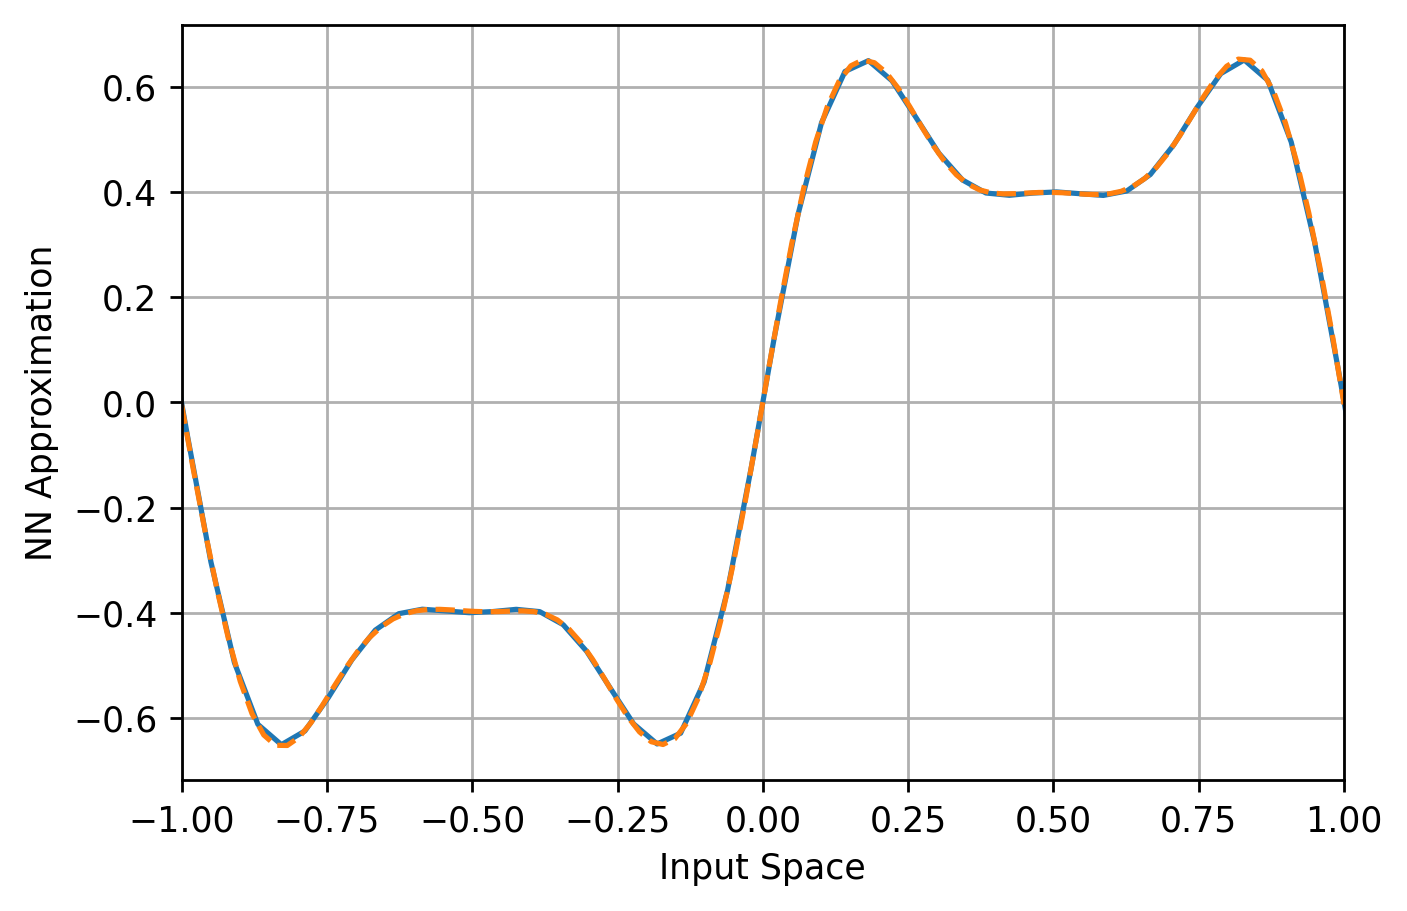

In [ ]:
val_fig, val_ax = plt.subplots(dpi=dpi)
val_ax.plot(x_vis, f_vis)
val_ax.plot(x_vis/2, model_1(x_vis/2), linestyle='--')
plt.xlim([-x_range/2, x_range/2])
plt.xlabel("Input Space")
plt.ylabel("NN Approximation")
plt.grid(True)
fig.show()
plt.savefig(topdir.joinpath("images", "model_1_approx.png"))

### Error Visualization

While we're here, we should also visualize the errors of the first approximation.

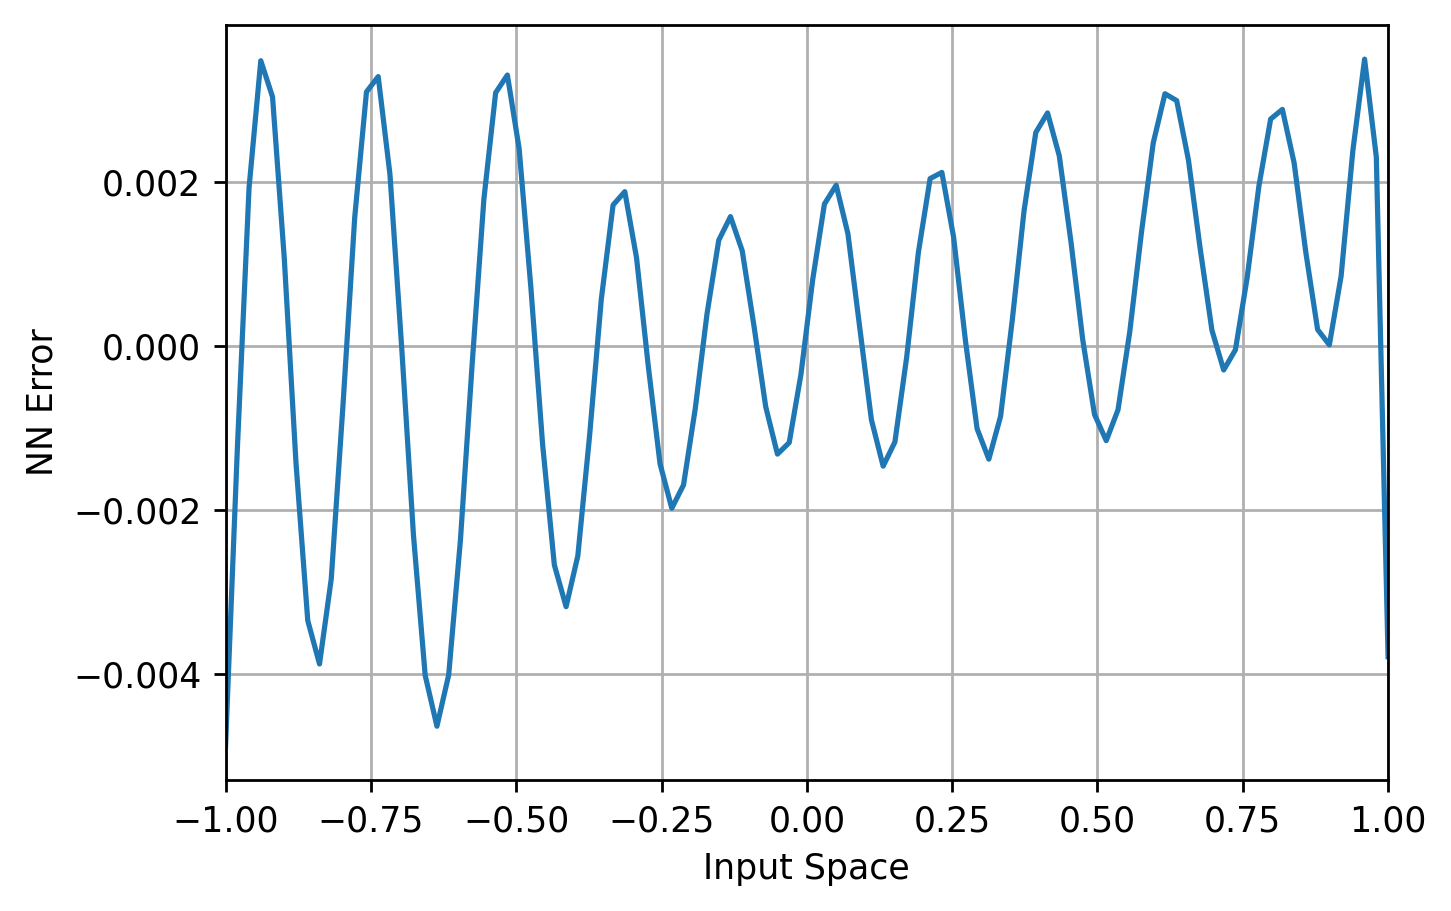

In [ ]:
# Compute a new visualization original function space for computing error
f_vis_new = f_u(np.linspace(-1, 1, n_elements))

# Plot the error
val_fig, val_ax = plt.subplots(dpi=dpi)
val_ax.plot(x_vis/2, (np.transpose(model_1(x_vis/2))-f_vis_new).transpose())
plt.xlim([-x_range/2, x_range/2])
plt.xlabel("Input Space")
plt.ylabel("NN Error")
plt.grid(True)
fig.show()
plt.savefig(topdir.joinpath("images", "model_1_error.png"))

## Save the Model

While we are here, it is wise to save our progress.
We will save the model here so that we can load the weights if we want to easily rerun the following steps.

In [ ]:
# Save the model for good measure
model_1.save(topdir.joinpath("models", "saved_models", "model_1"))
# Save the weights, which requires the correct model definition above to reload
model_1.save_weights(topdir.joinpath("models", "checkpoints", "model_1"))

INFO:tensorflow:Assets written to: drive/MyDrive/colab/EE5320/models/saved_models/model_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/colab/EE5320/models/saved_models/model_1/assets


We use this method to load the weights after they have been saved.
This is the cell to rerun if we want to reset the first network weights.

In [ ]:
# Restore the weights
model_1.load_weights(topdir.joinpath("models", "checkpoints", "model_1"))

## Train With EWC

### Copy Weights

First, we copy the top layer weights of the first model to the second model as a starting point.

In [ ]:
model_2.layers[-1].set_weights(model_1.layers[-1].get_weights())

### Train the Model

Next, we train the model with a modified EWC loss function.
This requires writing a custom Tensorflow training loop, which is non-trivial.

First, we compute the Fisher information matrix of the network on the previous dataset, excluding the top weights.
Next, we iterate over the batches with a modified loss function that includes the elastic penalty of the lower network weights.
This is done over a fewer number of iterations because of the bootstrapped knowledge from the previous learning.

In [ ]:
# Fisher information matrix calculation
def compute_precision_matrices(model, x_train, num_batches=1, batch_size=32):
    # task_set = task_set.repeat()
    precision_matrices = {n: tf.zeros_like(p.value()) for n, p in enumerate(model.trainable_variables[:-2])}
    # We need gradients of model params
    with tf.GradientTape() as tape:
        preds = model(x_train)
    # Attach gradients of ll to ll_grads
    ll_grads = tape.gradient(preds, model.trainable_variables[:-2])
    # Compute F_i as mean of gradients squared
    for i, g in enumerate(ll_grads):
        precision_matrices[i] += tf.math.reduce_mean(g ** 2, axis=0) / num_batches

    return precision_matrices

# EWC-specific penalty, excluding existing loss
def compute_elastic_penalty(F, theta, theta_A, alpha=25):
    penalty = 0
    for i, theta_i in enumerate(theta):
        _penalty = tf.math.reduce_sum(F[i] * (theta_i - theta_A[i]) ** 2)
        penalty += _penalty
    return 0.5*alpha*penalty

# Custom EWC loss function
def ewc_loss(labels, preds, model, F, theta_A):
    loss_b = tf.losses.mean_squared_error(labels, preds)
    penalty = compute_elastic_penalty(F, model.trainable_variables[:-2], theta_A)
    return loss_b + penalty

# EWC training step, optimized with @tf.function as a static graph for speed
@tf.function
def train_step(model, x_batch_train, y_batch_train, F, theta_A):
    with tf.GradientTape() as tape:
        preds = model(x_batch_train, training=True)
        loss_value = ewc_loss(y_batch_train, preds, model, F, theta_A)
    grads = tape.gradient(loss_value, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
    raw_loss_value = tf.losses.mean_squared_error(y_batch_train, preds)
    return loss_value, raw_loss_value

# Freeze the top layer learning
def freeze_top(model):
    model.layers[-1].trainable = False
    return

# Unfreeze the top layer learning
def unfreeze_top(model):
    model.layers[-1].trainable = True
    return

# Top EWC training method
def train_ewc(model, previous_data, X_train, y_train, batch_size=256, epochs=50):
    # Prepare the training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    # Prepare the validation dataset
    val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    val_dataset = val_dataset.batch(batch_size)

    # Penalize weights up to the final layer (weights and bias)
    theta_A = {n: p.value() for n, p in enumerate(model.trainable_variables[:-2].copy())}

    # Compute the Fisher information matrix
    num_batches = len(y_train)/batch_size*10
    F = compute_precision_matrices(model, previous_data, num_batches=num_batches)

    # Iterate over every epoch
    for epoch in range(epochs):

        # Print the epoch progress message
        print("\nEpoch {}/{}".format(epoch+1, epochs))
        # Create the progress bar
        pb_e = tf.keras.utils.Progbar(len(y_train)/batch_size, stateful_metrics=['loss', 'raw_loss'])
        # Iterate over every batch
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            # Run the optimized step function
            loss_value, raw_loss = train_step(model, x_batch_train, y_batch_train, F, theta_A)
            # Update the progress bar
            pb_e.add(1, values=[
                ('loss', tf.nn.compute_average_loss(loss_value)),
                ('raw_loss', tf.nn.compute_average_loss(raw_loss))
            ])
            # pb_e.add(1, values=[('loss', loss.result().numpy())])

# Train the second model
train_ewc(model_2, X_train, X_train_2, y_train_2, epochs=5)


Epoch 1/5
3125/3125 [==============================] - 16s 5ms/step - loss: 2.2332 - raw_loss: 0.2628

Epoch 2/5
3125/3125 [==============================] - 16s 5ms/step - loss: 0.4567 - raw_loss: 0.2485

Epoch 3/5
3125/3125 [==============================] - 15s 5ms/step - loss: 0.8592 - raw_loss: 0.2406

Epoch 4/5
3125/3125 [==============================] - 15s 5ms/step - loss: 0.3622 - raw_loss: 0.2462

Epoch 5/5
3125/3125 [==============================] - 16s 5ms/step - loss: 0.2314 - raw_loss: 0.2036


## Save the Weights

This is a good time to save the amended weights of both the first network and the second one.

In [ ]:
model_1.save(topdir.joinpath("models", "saved_models", "model_1_new"))
model_1.save_weights(topdir.joinpath("models", "checkpoints", "model_1_new"))

model_2.save(topdir.joinpath("models", "saved_models", "model_2"))
model_2.save_weights(topdir.joinpath("models", "checkpoints", "model_2"))

INFO:tensorflow:Assets written to: drive/MyDrive/colab/EE5320/models/saved_models/model_1_new/assets


INFO:tensorflow:Assets written to: drive/MyDrive/colab/EE5320/models/saved_models/model_1_new/assets


INFO:tensorflow:Assets written to: drive/MyDrive/colab/EE5320/models/saved_models/model_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/colab/EE5320/models/saved_models/model_2/assets


If we wish to reload the amended weights for experimentation, this is the cell to run.

In [ ]:
# Restore the weights
model_1.load_weights(topdir.joinpath("models", "checkpoints", "model_1_new"))
model_2.load_weights(topdir.joinpath("models", "checkpoints", "model_2"))

## EWC Visualization

Now we should see how the second training has done on the second function and affected the performance on the first one.

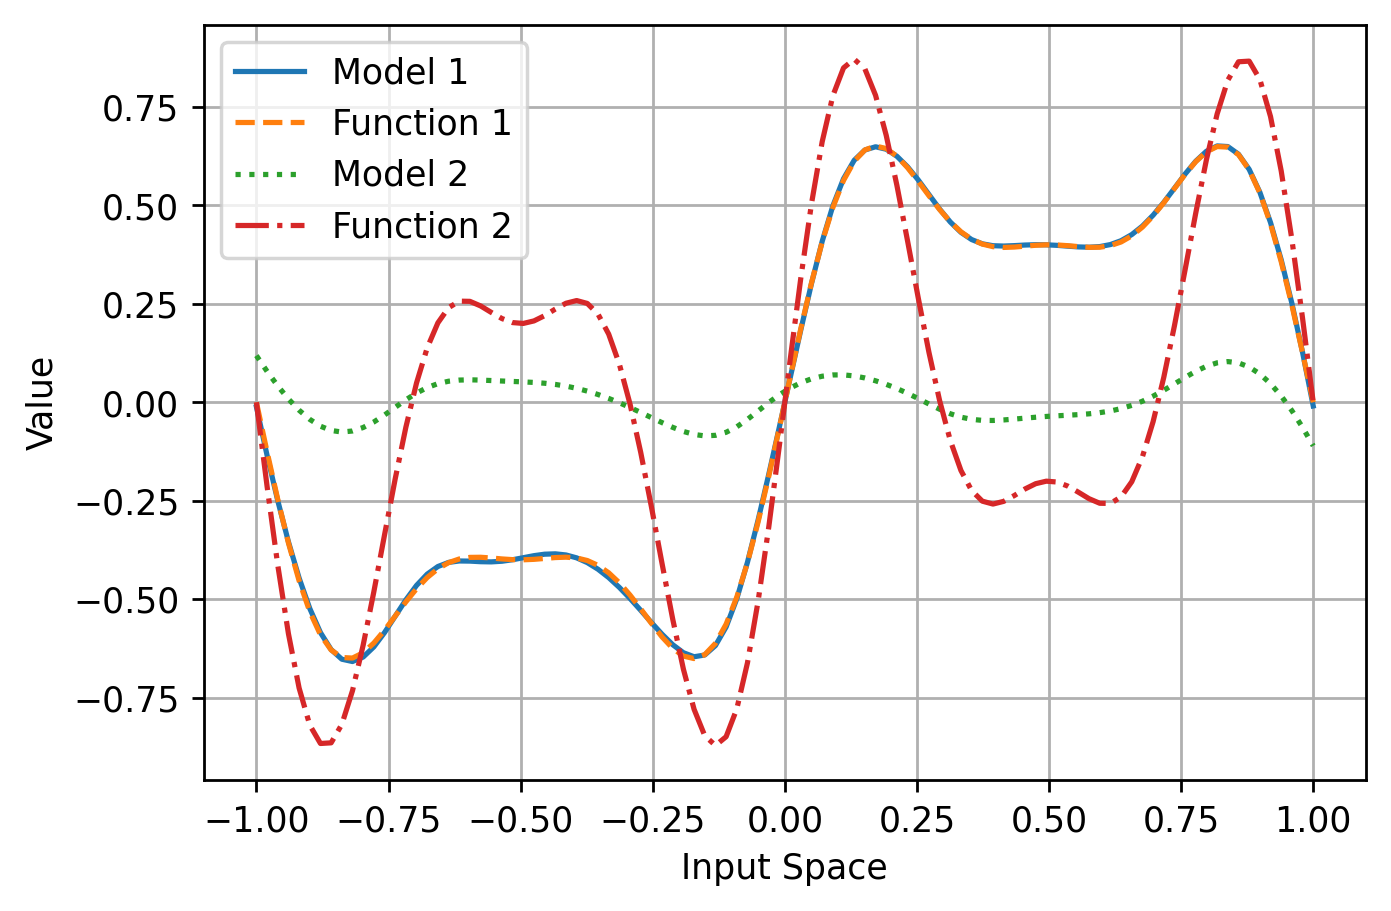

In [ ]:
# Create a new plotting basis for this visualiztion
x_vis_new = np.linspace(-1, 1, n_elements)
f_vis_new = f_u(x_vis_new)
f_vis_new_2 = f_u_2(x_vis_new)

# Plot all of the inferences and original functions
val_fig, val_ax = plt.subplots(dpi=dpi)
val_ax.plot(x_vis/2, model_1(x_vis/2), label='Model 1')
val_ax.plot(x_vis_new, f_vis_new, label='Function 1', linestyle='--')
val_ax.plot(x_vis/2, model_2(x_vis/2), label='Model 2', linestyle=':')
val_ax.plot(x_vis_new, f_vis_new_2, label='Function 2', linestyle='-.')
val_ax.legend()
plt.xlabel("Input Space")
plt.ylabel("Value")
plt.grid(True)

# Show and save
val_fig.show()
plt.savefig(topdir.joinpath("images", "model_comparison.png"))

### Errors Visualization Update

We should also see how the errors behave across the old and new data for both models.

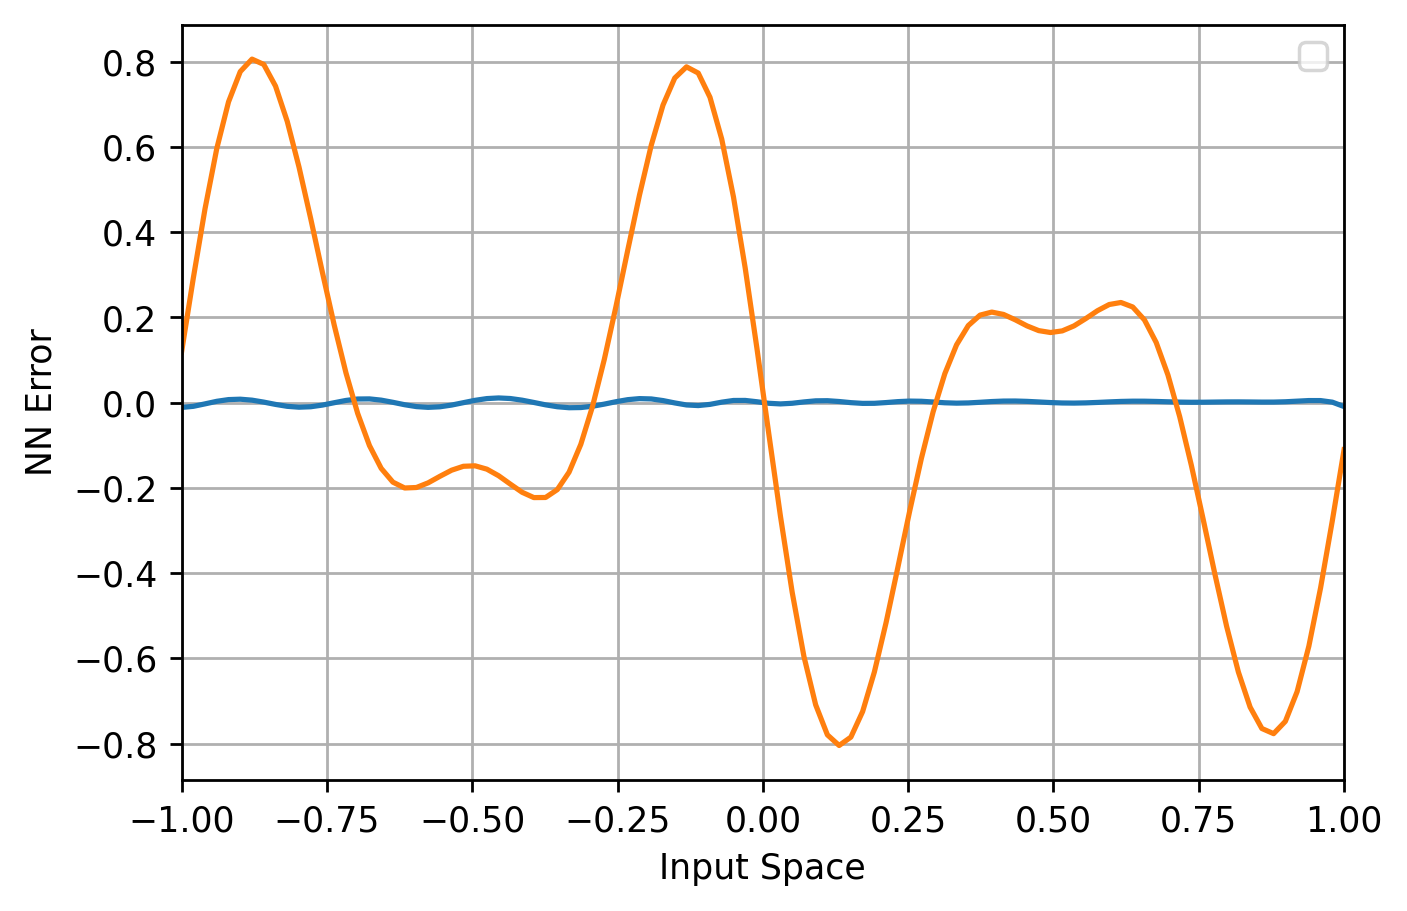

In [ ]:
# Plot the error
val_fig, val_ax = plt.subplots(dpi=dpi)
val_ax.plot(x_vis/2, (np.transpose(model_1(x_vis/2))-f_vis_new).transpose())
val_ax.plot(x_vis/2, (np.transpose(model_2(x_vis/2))-f_vis_new_2).transpose())
plt.xlim([-x_range/2, x_range/2])
plt.xlabel("Input Space")
plt.ylabel("NN Error")
plt.grid(True)
val_ax.legend()

fig.show()
plt.savefig(topdir.joinpath("images", "models_errors.png"))